In [34]:
from ctypes import *
import time
from sys import path
from os import sep
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dwf = cdll.LoadLibrary("libdwf.so")
constants_path = "/usr/share/digilent/waveforms/samples/py"
path.append(constants_path)
import dwfconstants as constants

In [35]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0)) #setting VDD = 3V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.00V


In [36]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
WTIME_REG = 0x83
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [37]:
write_register(ENABLE_REG, 0x01) #Power on / PON = 1
time.sleep(0.01)
write_register(ENABLE_REG, 0x0B) #Now, also RGBC enable / PON = 1, AEN = 1, WEN = 1
write_register(ATIME_REG, 0xF6) #To run for 24ms, upto a max count of 10,240
write_register(CONTROL_REG, 0x02) #Setting AGAIN=16
write_register(WTIME_REG, 0XFF) #Reseting the wtime register

True

In [38]:
#Function to test the sensor output
def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [43]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)

In [33]:
cleanup()
#call it everytime after work is done

In [ ]:
#Test case 1, Setting ATIME = 0xF6
write_register(CONTROL_REG,3)
write_register(ATIME_REG,0xF6)


wtime_val = [0xFF, 0xAB, 0x00]

for wtime in wtime_val:
    wait_time = (256-wtime)*2.4
    write_register(WTIME_REG, wtime)
    integration_time = (256-246)*2.4
    tital_time = (integration_time + wait_time)/1000.0
    time.sleep(tital_time)
    colors = read_colors()

    print(f"WAIT_REG: {wtime}, Clear: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")

WAIT_REG: 255, Clear: 3855, R: 1156, G: 1444, B: 1232
WAIT_REG: 171, Clear: 3646, R: 1100, G: 1370, B: 1176
WAIT_REG: 0, Clear: 3869, R: 1160, G: 1449, B: 1243


In [41]:
#Test case 2, Setting ATIME = 0xC0
write_register(CONTROL_REG,3)
write_register(ATIME_REG,0xC0)


wtime_val = [0xFF, 0xAB, 0x00]

for wtime in wtime_val:
    wait_time = (256-wtime)*2.4
    write_register(WTIME_REG, wtime)
    integration_time = (256-246)*2.4
    tital_time = (integration_time + wait_time)/1000.0
    time.sleep(tital_time)
    colors = read_colors()

    print(f"WAIT_REG: {wtime}, Clear: {colors['clear']}, R: {colors['red']}, G: {colors['green']}, B: {colors['blue']}")

WAIT_REG: 255, Clear: 3720, R: 1125, G: 1397, B: 1202
WAIT_REG: 171, Clear: 24431, R: 7372, G: 9171, B: 7878
WAIT_REG: 0, Clear: 24475, R: 7382, G: 9188, B: 7892


--- Test 2.0: Wait Time Sweep (Dual ATIME) ---

--- Testing ATIME: 0xf6 (24.0ms) ---
  Wait:   2.4ms -> Clear: 24312
  Wait: 204.0ms -> Clear: 3766
  Wait: 614.4ms -> Clear: 3692

--- Testing ATIME: 0xc0 (153.6ms) ---
  Wait:   2.4ms -> Clear: 24296
  Wait: 204.0ms -> Clear: 24257
  Wait: 614.4ms -> Clear: 24267


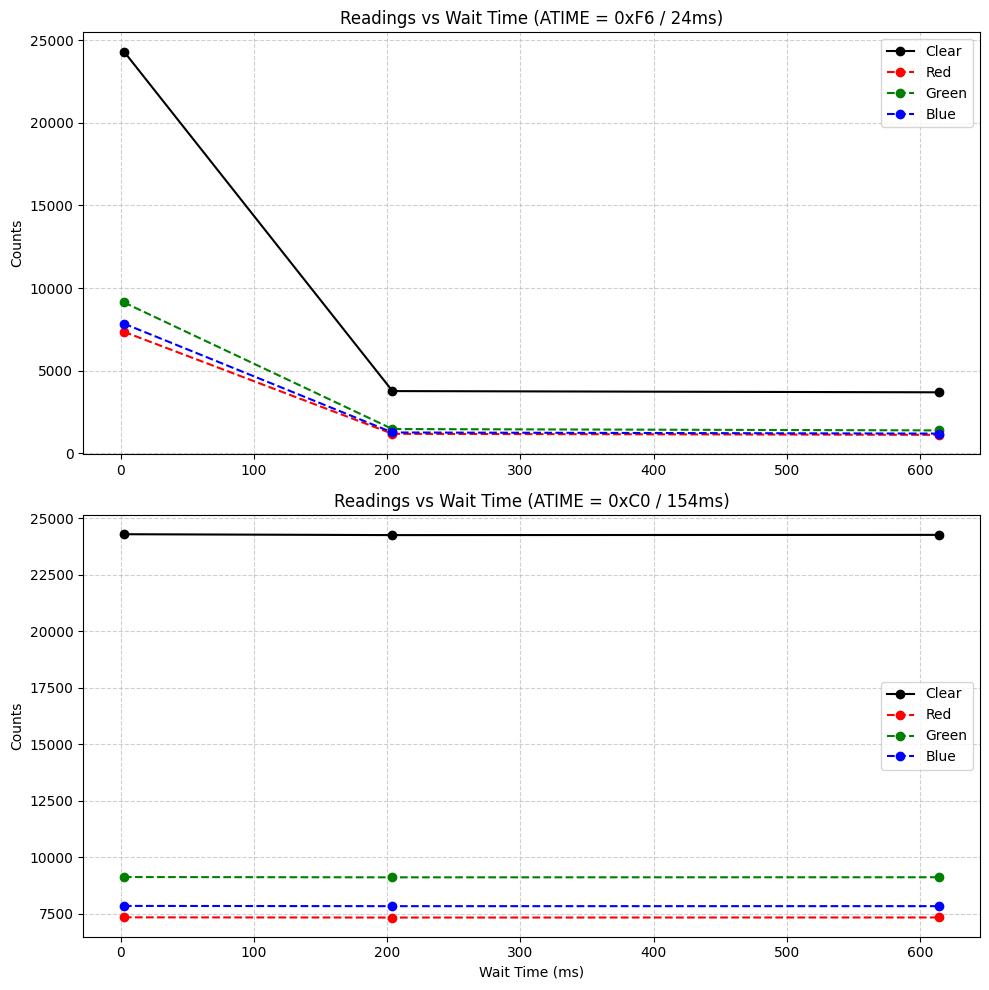

In [42]:
def test_wait_time_comparison():
    print("--- Test 2.0: Wait Time Sweep (Dual ATIME) ---")
    
    # 2. DEFINITIONS
    atime_cases = [0xF6, 0xC0] # 24ms and 154ms
    wtime_cases = [0xFF, 0xAB, 0x00] # 2.4ms, 204ms, 614ms
    
    all_results = []
    
    # 3. MAIN LOOP (Run for both ATIME cases)
    for atime_val in atime_cases:
        
        # Calculate Integ Time for logging
        integ_ms = (256 - atime_val) * 2.4
        print(f"\n--- Testing ATIME: {atime_val:#x} ({integ_ms:.1f}ms) ---")
        
        # Set ATIME
        write_register(ATIME_REG, atime_val)
        
        # Inner Loop: Sweep Wait Times
        for wtime_val in wtime_cases:
            # Set WTIME (Register 0x03 | 0x80 = 0x83)
            write_register(WTIME_REG, wtime_val)
            
            # Calculate Wait Time (ms)
            wait_ms = (256 - wtime_val) * 2.4
            
            # SLEEP: Must wait for (Integ + Wait)
            total_cycle_sec = (integ_ms + wait_ms) / 1000.0 + 0.05
            time.sleep(total_cycle_sec)
            
            # Read Data
            c = read_colors()
            
            if c:
                print(f"  Wait: {wait_ms:5.1f}ms -> Clear: {c['clear']}")
                all_results.append({
                    'ATIME_Hex': hex(atime_val),
                    'Integ_ms': integ_ms,
                    'Wait_ms': wait_ms,
                    'Clear': c['clear'],
                    'Red': c['red'],
                    'Green': c['green'],
                    'Blue': c['blue']
                })

    # 4. PLOTTING
    if all_results:
        df = pd.DataFrame(all_results)
        
        # Create 2 Subplots (Top and Bottom)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # --- Plot 1: ATIME 0xF6 (24ms) ---
        data_f6 = df[df['ATIME_Hex'] == hex(0xF6)]
        ax1.plot(data_f6['Wait_ms'], data_f6['Clear'], 'k-o', label='Clear')
        ax1.plot(data_f6['Wait_ms'], data_f6['Red'],   'r--o', label='Red')
        ax1.plot(data_f6['Wait_ms'], data_f6['Green'], 'g--o', label='Green')
        ax1.plot(data_f6['Wait_ms'], data_f6['Blue'],  'b--o', label='Blue')
        ax1.set_title(f'Readings vs Wait Time (ATIME = 0xF6 / 24ms)')
        ax1.set_ylabel('Counts')
        ax1.grid(True, linestyle='--', alpha=0.6)
        ax1.legend()
        
        # --- Plot 2: ATIME 0xC0 (154ms) ---
        data_c0 = df[df['ATIME_Hex'] == hex(0xC0)]
        ax2.plot(data_c0['Wait_ms'], data_c0['Clear'], 'k-o', label='Clear')
        ax2.plot(data_c0['Wait_ms'], data_c0['Red'],   'r--o', label='Red')
        ax2.plot(data_c0['Wait_ms'], data_c0['Green'], 'g--o', label='Green')
        ax2.plot(data_c0['Wait_ms'], data_c0['Blue'],  'b--o', label='Blue')
        ax2.set_title(f'Readings vs Wait Time (ATIME = 0xC0 / 154ms)')
        ax2.set_xlabel('Wait Time (ms)')
        ax2.set_ylabel('Counts')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

# Run
test_wait_time_comparison()